### <b> Ensemble Learning </b>

### CatBoost

CatBoost is an algorithm for gradient boosting on decision trees. It is developed by Yandex researchers and engineers and is used for search, recommendation systems, personal assistants, self-driving cars, weather prediction, and many other tasks at Yandex and in other companies, including CERN, Cloudflare, Careem taxi. It is open-source and can be used by anyone.

Let's study this with the help of a use case.


#### <b> Data Description </b>
The data consists of real historical data collected from 2010 & 2011. Employees are manually allowed or denied access to resources over time. You must create an algorithm capable of learning from this historical data to predict approval or denial for an unknown set of employees.

#### <b> File Descriptions </b>

**train.csv:** It is a training set. Each row has the action (ground truth), resources, and information about the employee's role at the time of approval.

**test.csv:** It is the test set for which predictions should be made. Each row asks whether an employee having the listed characteristics should have access to the listed resource.

The objective is to develop a model from historical data that will decide the access needs of an employee so that manual access transactions (grants and revocations) are reduced as the attributes of the employee change over time. The model will take information on the position of an employee and a resource code and return whether access should be given or not.

Note: The problem statement is from a Kaggle contest

The objective is to develop a model from historical data, that will decide the access needs of an employee, so that manual access transactions (grants and revocations) are reduced as the attributes of the employee change over time. The model will take information on the position of an employee and a resource code and return whether access should be given or not. <br>
`Note: The problem statement is from a Kaggle contest`

#### <b> Libraries Installation </b>

In [7]:
#To import libraries
import catboost
print(catboost.__version__)
!python --version

1.2.2
Python 3.11.5


#### <b> Reading the Data </b>

In [8]:
#To read the data
import pandas as pd
import os
import numpy as np
np.set_printoptions(precision=4)
import catboost
from catboost import *
from catboost import datasets

In [9]:
(train_df, test_df) = catboost.datasets.amazon()

In [10]:
train_df.head()

,ACTION,RESOURCE,MGR_ID,ROLE_ROLLUP_1,ROLE_ROLLUP_2,ROLE_DEPTNAME,ROLE_TITLE,ROLE_FAMILY_DESC,ROLE_FAMILY,ROLE_CODE
0,1,39353,85475,117961,118300,123472,117905,117906,290919,117908
1,1,17183,1540,117961,118343,123125,118536,118536,308574,118539
2,1,36724,14457,118219,118220,117884,117879,267952,19721,117880
3,1,36135,5396,117961,118343,119993,118321,240983,290919,118322
4,1,42680,5905,117929,117930,119569,119323,123932,19793,119325


The data will be displayed on the screen.

#### <b> Preparing Your Data </b>

Label values extraction

Action column contains the categorical feature. However, it is not available for test dataset, so you must drop the Action column.

In [11]:
y = train_df.ACTION
X = train_df.drop('ACTION', axis=1)

Categorical features declaration 


* <b>cat_features </b> is a one-dimensional array of categorical columns indices. 
* It has one of the following types: list, numpy.ndarray, pandas.DataFrame, and pandas.Series.

Now we will declare the cat feature that holds the categorical values present on train dataset.

In [12]:
#The type list is used here
cat_features = list(range(0, X.shape[1]))
print(cat_features)

[0, 1, 2, 3, 4, 5, 6, 7, 8]


In [13]:
#looking for label balance in dataset
print('Labels: {}'.format(set(y)))
print('Zero count = {}, One count = {}'.format(len(y) - sum(y), sum(y)))

Labels: {0, 1}
Zero count = 1897, One count = 30872


Ways to create **Pool** class
- In multiprocessing, the Pool class may handle a huge number of processes. It enables you to run several jobs in a single process due to its ability to queue the jobs.

In [14]:
#Specifying the dataset
dataset_dir = './amazon'
if not os.path.exists(dataset_dir):
    os.makedirs(dataset_dir)

#We will be able to work with files with/without header and with different separators
train_df.to_csv(
    os.path.join(dataset_dir, 'train.tsv'),
    index=False, sep='\t', header=False
)
test_df.to_csv(
    os.path.join(dataset_dir, 'test.tsv'),
    index=False, sep='\t', header=False
)

train_df.to_csv(
    os.path.join(dataset_dir, 'train.csv'),
    index=False, sep=',', header=True
)
test_df.to_csv(
    os.path.join(dataset_dir, 'test.csv'),
    index=False, sep=',', header=True
)

In [17]:
!head amazon/train.csv

'head' is not recognized as an internal or external command,
operable program or batch file.


In [18]:
from catboost.utils import create_cd
feature_names = dict()
for column, name in enumerate(train_df):
    if column == 0:
        continue
    feature_names[column - 1] = name
    
create_cd(
    label=0, 
    cat_features=list(range(1, train_df.columns.shape[0])),
   
    output_path=os.path.join(dataset_dir, 'train.cd')
)

In [19]:
!cat amazon/train.cd

'cat' is not recognized as an internal or external command,
operable program or batch file.


In [20]:
pool1 = Pool(data=X, label=y, cat_features=cat_features)
pool2 = Pool(
    data=os.path.join(dataset_dir, 'train.csv'), 
    delimiter=',', 
    column_description=os.path.join(dataset_dir, 'train.cd'),
    has_header=True
)
pool3 = Pool(data=X, cat_features=cat_features)

#Fastest way to create a Pool is to create it from numpy matrix.
#This way should be used if you want fast predictions
#or fastest way to load the data in python.

X_prepared = X.values.astype(str).astype(object)
#For FeaturesData class categorial features must have type str

pool4 = Pool(
    data=FeaturesData(
        cat_feature_data=X_prepared,
        cat_feature_names=list(X)
    ),
    label=y.values
)

print('Dataset shape')
print('dataset 1:' + str(pool1.shape) +
      '\ndataset 2:' + str(pool2.shape) + 
      '\ndataset 3:' + str(pool3.shape) +
      '\ndataset 4: ' + str(pool4.shape))

print('\n')
print('Column names')
print('dataset 1:')
print(pool1.get_feature_names()) 
print('\ndataset 2:')
print(pool2.get_feature_names())
print('\ndataset 3:')
print(pool3.get_feature_names())
print('\ndataset 4:')
print(pool4.get_feature_names())

Dataset shape
dataset 1:(32769, 9)
dataset 2:(32769, 9)
dataset 3:(32769, 9)
dataset 4: (32769, 9)


Column names
dataset 1:
['RESOURCE', 'MGR_ID', 'ROLE_ROLLUP_1', 'ROLE_ROLLUP_2', 'ROLE_DEPTNAME', 'ROLE_TITLE', 'ROLE_FAMILY_DESC', 'ROLE_FAMILY', 'ROLE_CODE']

dataset 2:
['RESOURCE', 'MGR_ID', 'ROLE_ROLLUP_1', 'ROLE_ROLLUP_2', 'ROLE_DEPTNAME', 'ROLE_TITLE', 'ROLE_FAMILY_DESC', 'ROLE_FAMILY', 'ROLE_CODE']

dataset 3:
['RESOURCE', 'MGR_ID', 'ROLE_ROLLUP_1', 'ROLE_ROLLUP_2', 'ROLE_DEPTNAME', 'ROLE_TITLE', 'ROLE_FAMILY_DESC', 'ROLE_FAMILY', 'ROLE_CODE']

dataset 4:
['RESOURCE', 'MGR_ID', 'ROLE_ROLLUP_1', 'ROLE_ROLLUP_2', 'ROLE_DEPTNAME', 'ROLE_TITLE', 'ROLE_FAMILY_DESC', 'ROLE_FAMILY', 'ROLE_CODE']


#### <b> Split Your Data into Train and Validation </b>

Let us split the data into **Train** and **Validation**.

In [21]:
from sklearn.model_selection import train_test_split
X_train, X_validation, y_train, y_validation = train_test_split(X, y, train_size=0.8, random_state=1234)

#### <b> Selecting the Objective Function </b>

Possible options for binary classification:

`Logloss`

`CrossEntropy` for probabilities in target

A **CatBoostClassifier** trains and applies models for the classification problems. It provides compatibility with the scikit-learn tools.

In [22]:
from catboost import CatBoostClassifier
model = CatBoostClassifier(
    iterations=5,
    learning_rate=0.1,
    #loss_function='CrossEntropy'
)
model.fit(
    X_train, y_train,
    cat_features=cat_features,
    eval_set=(X_validation, y_validation),
    verbose=False
)
print('Model is fitted: ' + str(model.is_fitted()))
print('Model params:')
print(model.get_params())

Model is fitted: True
Model params:
{'iterations': 5, 'learning_rate': 0.1}


#### <b> Stdout of the Training </b>
Stdout displays output directly to the screen console.
Output can take any form.
It can be output from a print statement, an expression statement, or even a direct prompt.


In [23]:
from catboost import CatBoostClassifier
model = CatBoostClassifier(
    iterations=15,
#verbose=5,
)
model.fit(
    X_train, y_train,
    cat_features=cat_features,
    eval_set=(X_validation, y_validation),
)

Learning rate set to 0.441257
0:	learn: 0.4220777	test: 0.4223741	best: 0.4223741 (0)	total: 55.5ms	remaining: 777ms
1:	learn: 0.3149660	test: 0.3151186	best: 0.3151186 (1)	total: 119ms	remaining: 772ms
2:	learn: 0.2621494	test: 0.2629766	best: 0.2629766 (2)	total: 176ms	remaining: 706ms
3:	learn: 0.2302316	test: 0.2302315	best: 0.2302315 (3)	total: 284ms	remaining: 781ms
4:	learn: 0.2060274	test: 0.2019603	best: 0.2019603 (4)	total: 336ms	remaining: 673ms
5:	learn: 0.1956107	test: 0.1894627	best: 0.1894627 (5)	total: 391ms	remaining: 587ms
6:	learn: 0.1870345	test: 0.1790904	best: 0.1790904 (6)	total: 449ms	remaining: 513ms
7:	learn: 0.1836943	test: 0.1748030	best: 0.1748030 (7)	total: 503ms	remaining: 440ms
8:	learn: 0.1807119	test: 0.1707896	best: 0.1707896 (8)	total: 562ms	remaining: 375ms
9:	learn: 0.1775777	test: 0.1662489	best: 0.1662489 (9)	total: 622ms	remaining: 311ms
10:	learn: 0.1762130	test: 0.1654446	best: 0.1654446 (10)	total: 692ms	remaining: 252ms
11:	learn: 0.1760650	

#### <b> Metric Calculation and Graph Plotting </b>

Let us perform metric calculation and graph plotting by importing the **CatBoostClassifier**.

In [24]:
from catboost import CatBoostClassifier
model = CatBoostClassifier(
    iterations=50,
    random_seed=63,
    learning_rate=0.5,
    custom_loss=['AUC', 'Accuracy']
)
model.fit(
    X_train, y_train,
    cat_features=cat_features,
    eval_set=(X_validation, y_validation),
    verbose=False,
    plot=True
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

#### <b> Model Comparison </b>

Let us compare the models.

In [25]:
model1 = CatBoostClassifier(
    learning_rate=0.7,
    iterations=100,
    random_seed=0,
    train_dir='learing_rate_0.7'
)

model2 = CatBoostClassifier(
    learning_rate=0.01,
    iterations=100,
    random_seed=0,
    train_dir='learing_rate_0.01'
)
model1.fit(
    X_train, y_train,
    eval_set=(X_validation, y_validation),
    cat_features=cat_features,
    verbose=False
)
model2.fit(
    X_train, y_train,
    eval_set=(X_validation, y_validation),
    cat_features=cat_features,
    verbose=False
)

In [26]:
from catboost import MetricVisualizer
MetricVisualizer(['learing_rate_0.01', 'learing_rate_0.7']).start()

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

#### <b> Best Iteration </b>

In [27]:
#Performing best iteration
from catboost import CatBoostClassifier
model = CatBoostClassifier(
    iterations=100,
    random_seed=63,
    learning_rate=0.5,
#use_best_model=False
)
model.fit(
    X_train, y_train,
    cat_features=cat_features,
    eval_set=(X_validation, y_validation),
    verbose=False,
    plot=True
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [28]:
print('Tree count: ' + str(model.tree_count_))

Tree count: 82


#### <b> Cross-Validation </b>

Cross-validation is a technique which involves reserving a particular sample of a dataset on which you do not train the model.
CatBoost allows to perform cross-validation on the given dataset.

In [29]:
#Performing cross-validation
from catboost import cv

params = {}
params['loss_function'] = 'Logloss'
params['iterations'] = 80
params['custom_loss'] = 'AUC'
params['random_seed'] = 63
params['learning_rate'] = 0.5

cv_data = cv(
    params = params,
    pool = Pool(X, label=y, cat_features=cat_features),
    fold_count=4,
    shuffle=True,
    partition_random_seed=0,
    plot=True,
    stratified=False,
    verbose=False
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/4]

bestTest = 0.1694293267
bestIteration = 51

Training on fold [1/4]

bestTest = 0.1629317796
bestIteration = 45

Training on fold [2/4]

bestTest = 0.1519866763
bestIteration = 74

Training on fold [3/4]

bestTest = 0.1534714429
bestIteration = 33



In [30]:
cv_data.head()

,iterations,test-Logloss-mean,test-Logloss-std,train-Logloss-mean,train-Logloss-std,test-AUC-mean,test-AUC-std
0,0,0.300306,0.003563,0.302136,0.002963,0.551287,0.011148
1,1,0.228557,0.007893,0.230263,0.003826,0.619480,0.019165
2,2,0.192566,0.006182,0.198289,0.003126,0.767270,0.015818
3,3,0.180724,0.006280,0.187878,0.003681,0.803570,0.009006
4,4,0.174026,0.006543,0.182572,0.003379,0.814640,0.007196


<b> Logloss </b> is indicative of how close the prediction probability is to the corresponding true value.

Let us print the **Best validation Logloss score**.

In [31]:
best_value = np.min(cv_data['test-Logloss-mean'])
best_iter = np.argmin(cv_data['test-Logloss-mean'])

print('Best validation Logloss score, not stratified: {:.4f}±{:.4f} on step {}'.format(
    best_value,
    cv_data['test-Logloss-std'][best_iter],
    best_iter)
)

Best validation Logloss score, not stratified: 0.1600±0.0079 on step 57


In [32]:
cv_data = cv(
    params = params,
    pool = Pool(X, label=y, cat_features=cat_features),
    fold_count=5,
    type = 'Classical',
    shuffle=True,
    partition_random_seed=0,
    plot=True,
    stratified=True,
    verbose=False
)

best_value = np.min(cv_data['test-Logloss-mean'])
best_iter = np.argmin(cv_data['test-Logloss-mean'])

print('Best validation Logloss score, stratified: {:.4f}±{:.4f} on step {}'.format(
    best_value,
    cv_data['test-Logloss-std'][best_iter],
    best_iter)
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/5]

bestTest = 0.1614486451
bestIteration = 31

Training on fold [1/5]

bestTest = 0.1551886688
bestIteration = 56

Training on fold [2/5]

bestTest = 0.156915781
bestIteration = 57

Training on fold [3/5]

bestTest = 0.1521221373
bestIteration = 59

Training on fold [4/5]

bestTest = 0.1576264978
bestIteration = 29

Best validation Logloss score, stratified: 0.1574±0.0036 on step 57


####  <b> Overfitting Detector </b>

If overfitting occurs, CatBoost can stop the training earlier than the training parameters dictate. For example, it can be stopped before the specified number of trees are built. This option is set in the starting parameters.

In [33]:
model_with_early_stop = CatBoostClassifier(
    iterations=200,
    random_seed=63,
    learning_rate=0.5,
    early_stopping_rounds=20
)
model_with_early_stop.fit(
    X_train, y_train,
    cat_features=cat_features,
    eval_set=(X_validation, y_validation),
    verbose=False,
    plot=True
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [34]:
print(model_with_early_stop.tree_count_)

30


In [35]:
model_with_early_stop = CatBoostClassifier(
    eval_metric='AUC',
    iterations=200,
    random_seed=63,
    learning_rate=0.5,
    early_stopping_rounds=20
)
model_with_early_stop.fit(
    X_train, y_train,
    cat_features=cat_features,
    eval_set=(X_validation, y_validation),
    verbose=False,
    plot=True
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [36]:
print(model_with_early_stop.tree_count_)

30


#### <b> Select Decision Boundary </b>

In classification problems with two or more classes, a decision boundary is a hypersurface that separates the underlying vector space into sets, keeping one for each class.

In [37]:
model = CatBoostClassifier(
    random_seed=63,
    iterations=200,
    learning_rate=0.03,
)
model.fit(
    X_train, y_train,
    cat_features=cat_features,
    verbose=False,
    plot=True
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

![Decision_Boundary](https://labcontent.simplicdn.net/data-content/content-assets/Data_and_AI/Applied_Machine_Learning/Images/Lesson_07_Ensemble_Learning/Decision_Boundary.png)

In [38]:
#Using utils to make the pattern easier
from catboost.utils import get_roc_curve
import sklearn
from sklearn import metrics

eval_pool = Pool(X_validation, y_validation, cat_features=cat_features)
curve = get_roc_curve(model, eval_pool)
(fpr, tpr, thresholds) = curve
roc_auc = sklearn.metrics.auc(fpr, tpr)

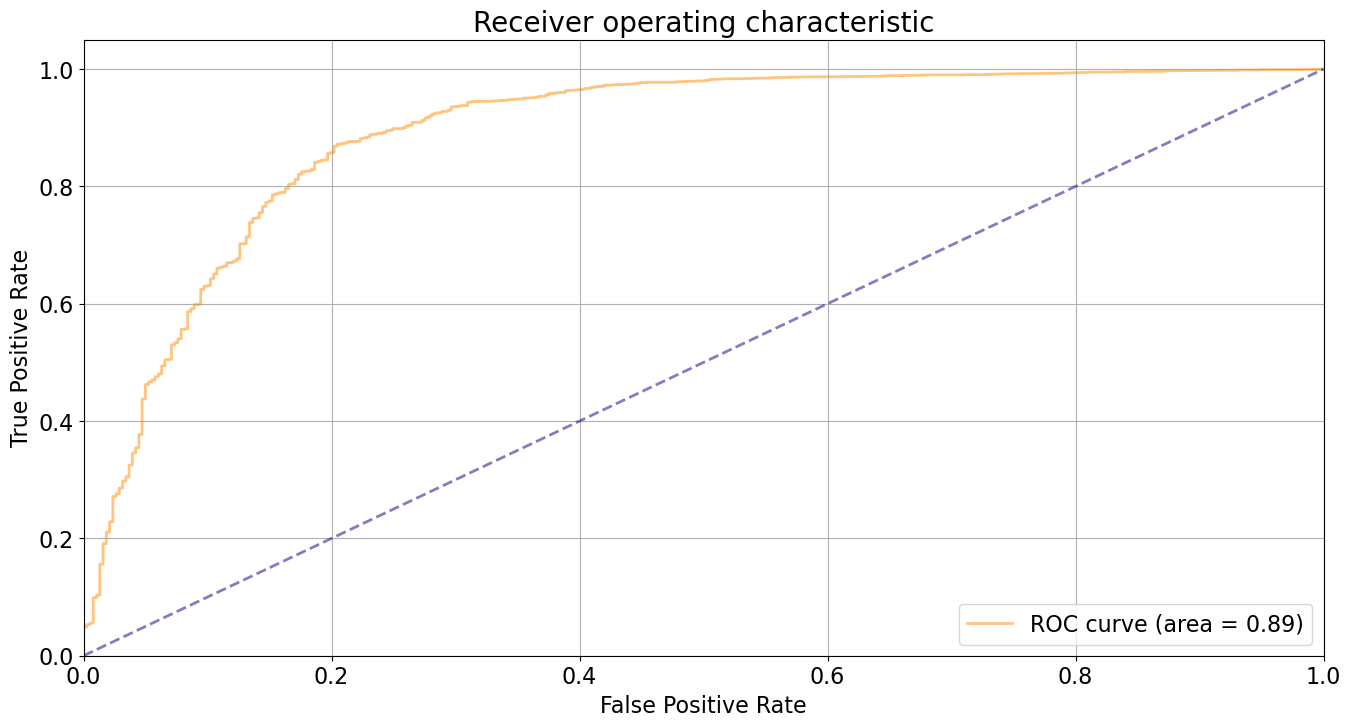

In [39]:
import matplotlib.pyplot as plt

plt.figure(figsize=(16, 8))
lw = 2

plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc, alpha=0.5)

plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--', alpha=0.5)

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.grid(True)
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('Receiver operating characteristic', fontsize=20)
plt.legend(loc="lower right", fontsize=16)
plt.show()

The above graph illustrates the diagnostic ability of a binary classifier system as its discrimination threshold is varied.

In [40]:
from catboost.utils import get_fpr_curve
from catboost.utils import get_fnr_curve

(thresholds, fpr) = get_fpr_curve(curve=curve)
(thresholds, fnr) = get_fnr_curve(curve=curve)

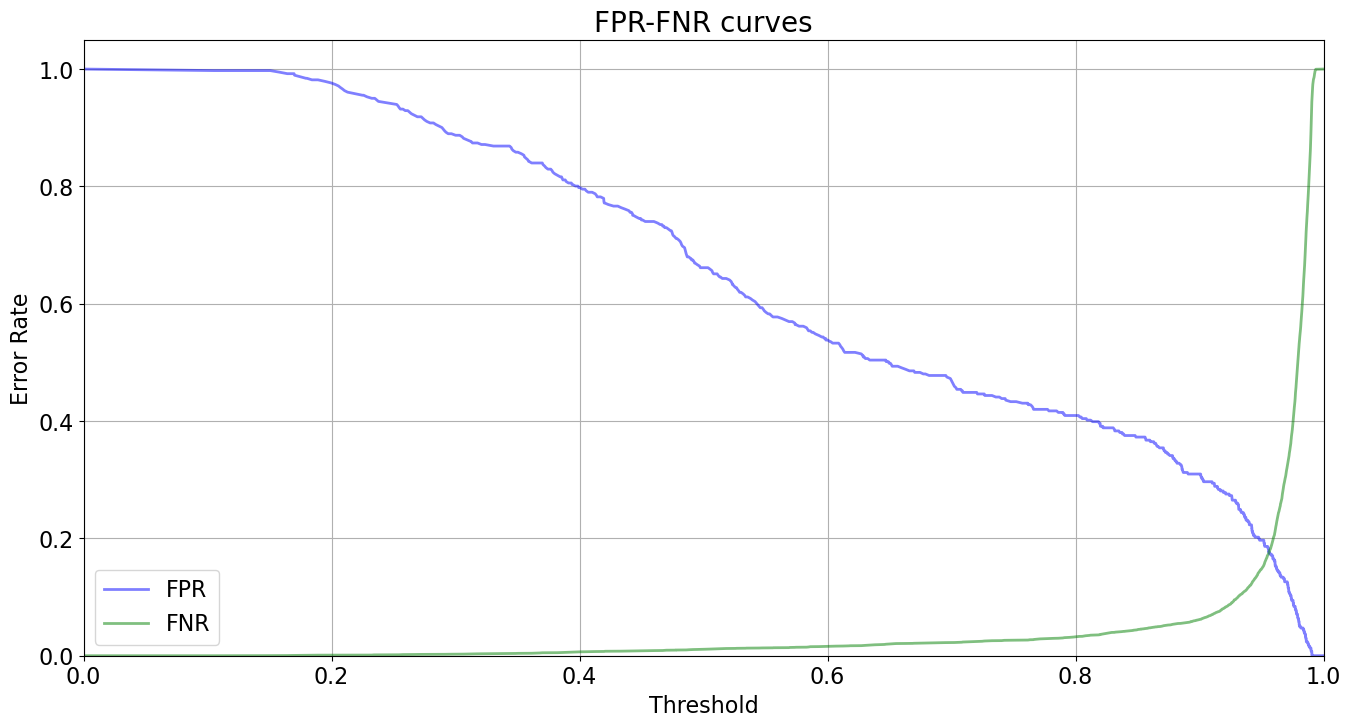

In [41]:
plt.figure(figsize=(16, 8))
lw = 2

plt.plot(thresholds, fpr, color='blue', lw=lw, label='FPR', alpha=0.5)
plt.plot(thresholds, fnr, color='green', lw=lw, label='FNR', alpha=0.5)

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.grid(True)
plt.xlabel('Threshold', fontsize=16)
plt.ylabel('Error Rate', fontsize=16)
plt.title('FPR-FNR curves', fontsize=20)
plt.legend(loc="lower left", fontsize=16)
plt.show()

The above graph displays the FPR-FNR curves for error rate and threshold.

In [42]:
from catboost.utils import select_threshold

print(select_threshold(model=model, data=eval_pool, FNR=0.01))
print(select_threshold(model=model, data=eval_pool, FPR=0.01))

0.48689529945049076
0.9899713850692811


#### <b> Snapshotting </b>

Catboost supports snapshotting. You can use it to recover training after an interruption or start training with previous results.

In [43]:
#!rm 'catboost_info/snapshot.bkp'
from catboost import CatBoostClassifier
model = CatBoostClassifier(
    iterations=100,
    save_snapshot=True,
    snapshot_file='snapshot.bkp',
    snapshot_interval=1,
    random_seed=43
)
model.fit(
    X_train, y_train,
    eval_set=(X_validation, y_validation),
    cat_features=cat_features,
    verbose=True
)

Learning rate set to 0.193326
0:	learn: 0.5565905	test: 0.5566217	best: 0.5566217 (0)	total: 32.6ms	remaining: 3.22s
1:	learn: 0.4642626	test: 0.4639935	best: 0.4639935 (1)	total: 66.2ms	remaining: 3.24s
2:	learn: 0.3989148	test: 0.3981304	best: 0.3981304 (2)	total: 126ms	remaining: 4.08s
3:	learn: 0.3516186	test: 0.3510286	best: 0.3510286 (3)	total: 152ms	remaining: 3.65s
4:	learn: 0.3164302	test: 0.3161297	best: 0.3161297 (4)	total: 210ms	remaining: 3.99s
5:	learn: 0.2906047	test: 0.2905494	best: 0.2905494 (5)	total: 224ms	remaining: 3.51s
6:	learn: 0.2710475	test: 0.2708899	best: 0.2708899 (6)	total: 252ms	remaining: 3.35s
7:	learn: 0.2538458	test: 0.2539798	best: 0.2539798 (7)	total: 316ms	remaining: 3.63s
8:	learn: 0.2399269	test: 0.2401350	best: 0.2401350 (8)	total: 380ms	remaining: 3.84s
9:	learn: 0.2298664	test: 0.2304173	best: 0.2304173 (9)	total: 451ms	remaining: 4.06s
10:	learn: 0.2180381	test: 0.2161946	best: 0.2161946 (10)	total: 533ms	remaining: 4.31s
11:	learn: 0.2089276

96:	learn: 0.1658729	test: 0.1577104	best: 0.1575678 (80)	total: 6.15s	remaining: 190ms
97:	learn: 0.1658312	test: 0.1577005	best: 0.1575678 (80)	total: 6.22s	remaining: 127ms
98:	learn: 0.1657567	test: 0.1576310	best: 0.1575678 (80)	total: 6.28s	remaining: 63.5ms
99:	learn: 0.1655047	test: 0.1576241	best: 0.1575678 (80)	total: 6.39s	remaining: 0us

bestTest = 0.1575677776
bestIteration = 80

Shrink model to first 81 iterations.


#### <b> Model Predictions </b>

predict_proba gives you the probabilities for the target in array form. The number of probabilities for each row is equal to the number of categories in the target variable.

In [44]:
print(model.predict_proba(X=X_validation))

[[0.0508 0.9492]
 [0.0181 0.9819]
 [0.0179 0.9821]
 ...
 [0.0161 0.9839]
 [0.017  0.983 ]
 [0.0236 0.9764]]


In [45]:
print(model.predict(data=X_validation))

[1 1 1 ... 1 1 1]


In [46]:
raw_pred = model.predict(
    data=X_validation,
    prediction_type='RawFormulaVal'
)
print(raw_pred)

[2.9282 3.9947 4.0077 ... 4.1115 4.06   3.7207]


In [47]:
from numpy import exp

#Calculating sigmoid
sigmoid = lambda x: 1 / (1 + exp(-x))

probabilities = sigmoid(raw_pred)

print(probabilities)

[0.9492 0.9819 0.9821 ... 0.9839 0.983  0.9764]


The probabilities will be displayed on the screen.

In [48]:
X_prepared = X_validation.values.astype(str).astype(object)
#For FeaturesData class categorial features must have type str

fast_predictions = model.predict_proba(
    X=FeaturesData(
        cat_feature_data=X_prepared,
        cat_feature_names=list(X_validation)
    )
)
print(fast_predictions)

[[0.0508 0.9492]
 [0.0181 0.9819]
 [0.0179 0.9821]
 ...
 [0.0161 0.9839]
 [0.017  0.983 ]
 [0.0236 0.9764]]


#### <b> Staged Prediction </b>

CatBoost allows to apply a trained model and calculate the results for each i-th tree of the model, taking into consideration only the trees in the range [0; i).

In [49]:
predictions_gen = model.staged_predict_proba(
    data=X_validation,
    ntree_start=0, 
    ntree_end=5, 
    eval_period=1
)
try:
    for iteration, predictions in enumerate(predictions_gen):
        print('Iteration ' + str(iteration) + ', predictions:')
        print(predictions)
except Exception:
    pass

Iteration 0, predictions:
[[0.4154 0.5846]
 [0.4154 0.5846]
 [0.4154 0.5846]
 ...
 [0.4154 0.5846]
 [0.4154 0.5846]
 [0.4154 0.5846]]
Iteration 1, predictions:
[[0.3476 0.6524]
 [0.3476 0.6524]
 [0.3476 0.6524]
 ...
 [0.3476 0.6524]
 [0.3476 0.6524]
 [0.3476 0.6524]]
Iteration 2, predictions:
[[0.292  0.708 ]
 [0.292  0.708 ]
 [0.2978 0.7022]
 ...
 [0.2978 0.7022]
 [0.292  0.708 ]
 [0.2978 0.7022]]
Iteration 3, predictions:
[[0.2485 0.7515]
 [0.2485 0.7515]
 [0.2538 0.7462]
 ...
 [0.2538 0.7462]
 [0.2485 0.7515]
 [0.2538 0.7462]]
Iteration 4, predictions:
[[0.2126 0.7874]
 [0.2126 0.7874]
 [0.2173 0.7827]
 ...
 [0.2173 0.7827]
 [0.2126 0.7874]
 [0.2173 0.7827]]


#### <b> Solving Multiclass Classification Problem </b>

Let us solve the **Multiclass Classification Problem** using the **CatBoostClassifier.**

In [50]:
from catboost import CatBoostClassifier
model = CatBoostClassifier(
    iterations=50,
    random_seed=43,
    loss_function='MultiClass'
)
model.fit(
    X_train, y_train,
    cat_features=cat_features,
    eval_set=(X_validation, y_validation),
    verbose=False,
    plot=True
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

For multiclass problems with many classes, sometimes, it's better to solve classification problems using ranking. To do that, we will build a dataset with groups. Every group will represent one object from our initial dataset. But it will have one additional categorical feature, a possible class value. Target values will be equal to 1 if the class value is equal to the correct class and 0 otherwise. Thus, each group will have exactly one 1 in labels and some zeros. You can put all possible class values in the group, or you can try setting only hard negatives if there are too many labels. We'll show this approach as an example of a binary classification problem.

In [51]:
#Defining custom function to build multiclass ranking
from copy import deepcopy
def build_multiclass_ranking_dataset(X, y, cat_features, label_values=[0,1], start_group_id=0):
    ranking_matrix = []
    ranking_labels = []
    group_ids = []

    X_train_matrix = X.values
    y_train_vector = y.values

    for obj_idx in range(X.shape[0]):
        obj = list(X_train_matrix[obj_idx])

        for label in label_values:
            obj_of_given_class = deepcopy(obj)
            obj_of_given_class.append(label)
            ranking_matrix.append(obj_of_given_class)
            ranking_labels.append(float(y_train_vector[obj_idx] == label)) 
            group_ids.append(start_group_id + obj_idx)
        
    final_cat_features = deepcopy(cat_features)
    final_cat_features.append(X.shape[1]) # new feature that we are adding should be categorical.
    return Pool(ranking_matrix, ranking_labels, cat_features=final_cat_features, group_id = group_ids)

In [52]:
from catboost import CatBoost
params = {'iterations':150, 'learning_rate':0.01, 'l2_leaf_reg':30, 'random_seed':0, 'loss_function':'QuerySoftMax'}

groupwise_train_pool = build_multiclass_ranking_dataset(X_train, y_train, cat_features, [0,1])
groupwise_eval_pool = build_multiclass_ranking_dataset(X_validation, y_validation, cat_features, [0,1], X_train.shape[0])

model = CatBoost(params)
model.fit(
    X=groupwise_train_pool,
    verbose=False,
    eval_set=groupwise_eval_pool,
    plot=True
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Making predictions with ranking mode

In [53]:
import math

obj = list(X_validation.values[0])
ratings = []
for label in [0,1]:
    obj_with_label = deepcopy(obj)
    obj_with_label.append(label)
    rating = model.predict([obj_with_label])[0]
    ratings.append(rating)
print('Raw values:', np.array(ratings))

def soft_max(values):
    return [math.exp(val) / sum([math.exp(val) for val in values]) for val in values]

print('Probabilities', np.array(soft_max(ratings)))

Raw values: [-0.471   0.4713]
Probabilities [0.2804 0.7196]


#### <b> Metric Evaluation on a New Dataset </b>

Let us perform **Metric Evaluation** on a new dataset using the training data.

In [54]:
model = CatBoostClassifier(
    random_seed=63,
    iterations=200,
    learning_rate=0.03,
)
model.fit(
    X_train, y_train,
    cat_features=cat_features,
    verbose=50
)

0:	learn: 0.6569860	total: 62.7ms	remaining: 12.5s
50:	learn: 0.1923495	total: 5.15s	remaining: 15.1s
100:	learn: 0.1655631	total: 10.9s	remaining: 10.7s
150:	learn: 0.1570882	total: 17.5s	remaining: 5.68s
199:	learn: 0.1538475	total: 24.3s	remaining: 0us


In [55]:
metrics = model.eval_metrics(
    data=pool1,
    metrics=['Logloss','AUC'],
    ntree_start=0,
    ntree_end=0,
    eval_period=1,
    plot=True
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [56]:
print('AUC values:')
print(np.array(metrics['AUC']))

AUC values:
[0.4998 0.538  0.5504 0.5888 0.6536 0.6515 0.6476 0.648  0.7117 0.731
 0.7277 0.7278 0.7299 0.7298 0.7275 0.7273 0.7336 0.735  0.7445 0.7606
 0.7627 0.7627 0.7731 0.7769 0.7866 0.7985 0.7986 0.8008 0.8004 0.8004
 0.8191 0.8357 0.8518 0.8666 0.8851 0.8855 0.8886 0.8931 0.8936 0.8991
 0.9033 0.9115 0.9126 0.9136 0.9148 0.9163 0.9177 0.9184 0.9206 0.9211
 0.9259 0.9289 0.9291 0.9324 0.9329 0.9334 0.9338 0.9351 0.9361 0.937
 0.9378 0.938  0.9383 0.9393 0.9405 0.9416 0.943  0.9441 0.945  0.9448
 0.9457 0.9458 0.9463 0.9464 0.9467 0.9469 0.9484 0.9494 0.9503 0.9515
 0.9523 0.9528 0.9539 0.9546 0.955  0.9556 0.9559 0.9563 0.9565 0.9567
 0.9572 0.9576 0.9583 0.9591 0.9602 0.9608 0.9613 0.9619 0.9622 0.9625
 0.9629 0.9633 0.9637 0.9639 0.9647 0.9655 0.9661 0.9667 0.9673 0.9675
 0.9682 0.9687 0.9691 0.9694 0.9699 0.9703 0.9706 0.9707 0.9711 0.9715
 0.9716 0.972  0.9723 0.9726 0.9728 0.973  0.9731 0.9731 0.9733 0.9734
 0.9738 0.9738 0.9739 0.974  0.9741 0.9742 0.9744 0.9744 0.9745 0.9

#### <b> Feature Importances </b>

<b> Feature importance </b> refers to techniques that assign a score to input features based on how useful they are at predicting a target variable.

In [57]:
#To find feature importance
model.get_feature_importance(prettified=True)

,Feature Id,Importances
0,RESOURCE,23.053159
1,ROLE_DEPTNAME,17.444028
2,MGR_ID,15.435686
3,ROLE_ROLLUP_2,13.141622
4,ROLE_CODE,10.487834
5,ROLE_FAMILY_DESC,7.121037
6,ROLE_TITLE,6.394562
7,ROLE_FAMILY,4.287269
8,ROLE_ROLLUP_1,2.634803


Scores are assigned to the input features.

#### <b> Feature Evaluation </b>

Let us perform feature evaluation using the **eval_features( )** function.

In [58]:
from catboost.eval.catboost_evaluation import *
learn_params = {'iterations': 20, # 2000
                'learning_rate': 0.5, #we set big learning_rate, because we have small iterations
                'random_seed': 0,
                'verbose': False,
                'loss_function' : 'Logloss',
                'boosting_type': 'Plain'}
evaluator = CatboostEvaluation('amazon/train.tsv',
                               fold_size=10000, #<= 50% of dataset
                               fold_count=20,
                               column_description='amazon/train.cd',
                               partition_random_seed=0,
                               #working_dir=... 
)
result = evaluator.eval_features(learn_config=learn_params,
                                 eval_metrics=['Logloss', 'Accuracy'],
                                 features_to_eval=[6, 7, 8])

In [59]:
from catboost.eval.evaluation_result import *
logloss_result = result.get_metric_results('Logloss')
logloss_result.get_baseline_comparison(
    ScoreConfig(ScoreType.Rel, overfit_iterations_info=False)
)

,PValue,Score,Quantile 0.005,Quantile 0.995,Decision
Features: 6,0.000189,1.010962,0.601546,1.491466,GOOD
Features: 7,0.681322,-0.033237,-0.348140,0.308468,UNKNOWN
Features: 8,0.005111,-0.439271,-0.771474,-0.110104,BAD


#### <b> Saving the Model </b>

In [60]:
my_best_model = CatBoostClassifier(iterations=10)
my_best_model.fit(
    X_train, y_train,
    eval_set=(X_validation, y_validation),
    cat_features=cat_features,
    verbose=False
)
my_best_model.save_model('catboost_model.bin')
my_best_model.save_model('catboost_model.json', format='json')

In [61]:
my_best_model.load_model('catboost_model.bin')
print(my_best_model.get_params())
print(my_best_model.random_seed_)

{'iterations': 10, 'loss_function': 'Logloss', 'verbose': 0}
0


### **Hyperparameter Tunning**

Hyperparameter tuning is the process of determining the right combination of hyperparameters that allows the model to maximize model performance. Setting the correct combination of hyperparameters is the only way to extract the maximum performance out of models.

#### <b> Training Speed </b>

In [62]:
from catboost import CatBoost
fast_model = CatBoostClassifier(
    random_seed=63,
    iterations=150,
    learning_rate=0.01,
    boosting_type='Plain',
    bootstrap_type='Bernoulli',
    subsample=0.5,
    one_hot_max_size=20,
    rsm=0.5,
    leaf_estimation_iterations=5,
    max_ctr_complexity=1)

fast_model.fit(
    X_train, y_train,
    cat_features=cat_features,
    verbose=False,
    plot=True
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

#### <b> Accuracy </b>

In [63]:
tunned_model = CatBoostClassifier(
    random_seed=63,
    iterations=1000,
    learning_rate=0.03,
    l2_leaf_reg=3,
    bagging_temperature=1,
    random_strength=1,
    one_hot_max_size=2,
    leaf_estimation_method='Newton'
)
tunned_model.fit(
    X_train, y_train,
    cat_features=cat_features,
    verbose=False,
    eval_set=(X_validation, y_validation),
    plot=True
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

#### <b> Training the Model after Parameter Tuning </b>

In [64]:
best_model = CatBoostClassifier(
    random_seed=63,
    iterations=int(tunned_model.tree_count_ * 1.2),
)
best_model.fit(
    X, y,
    cat_features=cat_features,
    verbose=100
)

Learning rate set to 0.042562
0:	learn: 0.6431230	total: 61.2ms	remaining: 1m 6s
100:	learn: 0.1543277	total: 13.8s	remaining: 2m 14s
200:	learn: 0.1468157	total: 30.4s	remaining: 2m 13s
300:	learn: 0.1432971	total: 46.6s	remaining: 2m
400:	learn: 0.1394889	total: 1m 3s	remaining: 1m 46s
500:	learn: 0.1366166	total: 1m 20s	remaining: 1m 32s
600:	learn: 0.1336685	total: 1m 36s	remaining: 1m 17s
700:	learn: 0.1305189	total: 1m 54s	remaining: 1m 2s
800:	learn: 0.1278539	total: 2m 12s	remaining: 46.2s
900:	learn: 0.1250599	total: 2m 30s	remaining: 30s
1000:	learn: 0.1223452	total: 2m 48s	remaining: 13.4s
1080:	learn: 0.1201653	total: 3m 4s	remaining: 0us


#### <b> Calculate Prediction </b>

In [65]:
#Let us calculate contest predictions
X_test = test_df.drop('id', axis=1)
test_pool = Pool(data=X_test, cat_features=cat_features)
contest_predictions = best_model.predict_proba(test_pool)
print('Predictions:')
print(contest_predictions)

Predictions:
[[0.2987 0.7013]
 [0.018  0.982 ]
 [0.0137 0.9863]
 ...
 [0.0049 0.9951]
 [0.0384 0.9616]
 [0.013  0.987 ]]


### <b>Voting Ensemble</b>

Voting is one of the simplest ways of combining the predictions from multiple machine learning algorithms.

It works by first creating two or more standalone models from your training dataset. A Voting Classifier can then be used to wrap your models and average the predictions of the submodels when asked to make predictions for new data.

The predictions of the submodels can be weighted, but specifying the weights for classifiers manually or even heuristically is difficult. More advanced methods can learn how to best weight the predictions from submodels, but this is called stacking (stacked generalization) and is currently not provided in scikit-learn.

You can create a voting ensemble model for classification using the **VotingClassifier** class.

The code below provides an example of combining the predictions of logistic regression, classification, and regression trees and support vector machines together for a classification problem.


In [66]:
#Voting Ensemble for Classification
import pandas
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import VotingClassifier

url = "https://raw.githubusercontent.com/jbrownlee/Datasets/master/pima-indians-diabetes.data.csv"
names = ['preg', 'plas', 'pres', 'skin', 'test', 'mass', 'pedi', 'age', 'class']
dataframe = pandas.read_csv(url, names=names)

array = dataframe.values
X = array[:,0:8]
Y = array[:,8]
seed = 7
kfold = model_selection.KFold(n_splits=10)

#Create the sub models
estimators = []
model1 = LogisticRegression()
estimators.append(('logistic', model1))
model2 = DecisionTreeClassifier()
estimators.append(('cart', model2))
model3 = SVC()
estimators.append(('svm', model3))

#Create the ensemble model
ensemble = VotingClassifier(estimators)
results = model_selection.cross_val_score(ensemble, X, Y, cv=kfold)
print(results.mean())

C:\Users\srika\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\srika\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

0.7669002050580997
